# Example of how neural heterogeneity improves song coding

In [1]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg, stats
import sys

from record_0_main import smlt_ma
from disp import set_plot

cc = np.concatenate

FPS = 30.03
DT = 1/FPS

In [2]:
song_modes = ['Q', 'S', 'P']

def sample_song(pi, nt):
    """
    Sample a 3-mode Markov song.
    
    pi: transition matrix (row = from, col = to)
    """
    # get stationary distribution to use for initial condition
    evs, evecs = linalg.eig(pi, left=True, right=False)
    idx_ev_1 = np.argmin(np.abs(evs-1))
    p_0 = evecs[:, idx_ev_1]
    p_0 /= np.sum(p_0)
    
    song = np.repeat('', nt)
    
    song[0] = np.random.choice(song_modes, p=p_0)
    
    for t_ in range(1, nt):
        p_next = pi[song_modes.index(song[t_-1]), :]
        song[t_] = np.random.choice(song_modes, p=p_next)
        
    i_s = song == 'S'
    i_p = song == 'P'
    
    return i_s, i_p, song

def get_h_naive(rs, nbin, base=2):
    """Naive netropy of estimate (i.e. not corrected for sampling)."""
    nnrn = rs.shape[1]
    bins = [np.linspace(0, 1, nbin) for r in rs.T]
    
    p_singles = [np.histogram(rs[:, cnrn], bins[cnrn], density=True)[0] for cnrn in range(nnrn)]
    
    p_joint = np.histogramdd(rs, bins, density=True)[0]
    
    h_singles = [stats.entropy(p_single/p_single.sum(), base=base) for p_single in p_singles]
    
    h_joint = stats.entropy(p_joint.flatten()/p_joint.sum(), base=base)
    
    return h_joint, h_singles

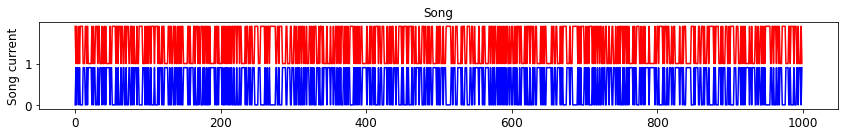

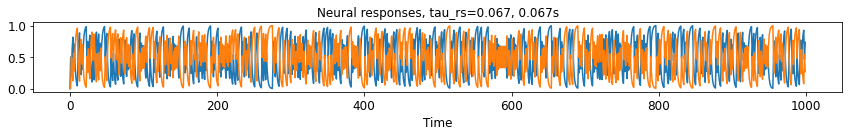

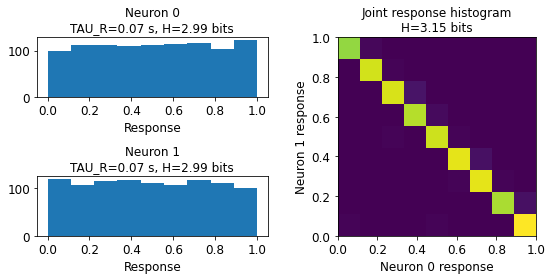

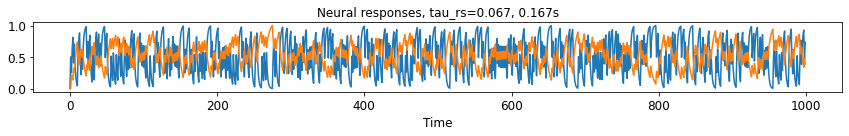

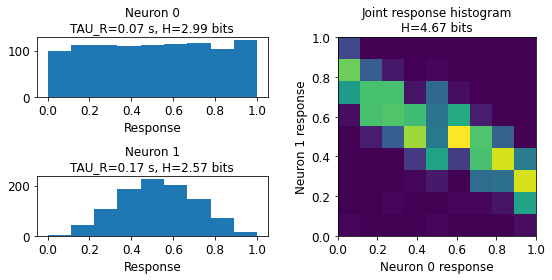

In [3]:
# test
N = 2
NBIN = 9

pi = np.array([
    [0, .5, .5],
    [0, .5, .5],
    [0, .5, .5],
])

# make song
i_s, i_p, song = sample_song(pi, 1000)

fig, ax = plt.subplots(1, 1, figsize=(12, 2), tight_layout=True, sharex=True)
ax.plot(i_s*.9, c='b')
ax.plot(i_p*.9 + 1, c='r')
set_plot(ax, y_label='Song current', title='Song')


for tau_r in [2*DT*np.ones(N), np.array([2*DT, 5*DT])]:
    nrn_params = {
        'TAU_R': tau_r,
        'TAU_A': np.inf*np.ones(N),
        'X_S': np.linspace(1, 0, 2),
        'X_P': np.linspace(0, 1, 2),
    }

    # compute neural response
    rs = smlt_ma(i_s, i_p, nrn_params, dt=DT)
    
    rs /= rs.max(axis=0)

    h_joint, h_singles = get_h_naive(rs, nbin=NBIN, base=2)

    fig, ax = plt.subplots(1, 1, figsize=(12, 2), tight_layout=True)
    ax.plot(rs)
    set_plot(ax, x_label='Time', title=f'Neural responses, tau_rs=' + ', '.join([f'{tau_r[cnrn]:.3f}' for cnrn in range(N)]) + 's')

    gs = gridspec.GridSpec(2, 2)
    fig = plt.figure(figsize=(8, 4), tight_layout=True)
    axs = np.array([fig.add_subplot(loc) for loc in [gs[0, 0], gs[1, 0], gs[:, 1]]])

    axs[0].hist(rs[:, 0], bins=NBIN)
    axs[1].hist(rs[:, 1], bins=NBIN)
    axs[2].hist2d(rs[:, 0], rs[:, 1], bins=NBIN)
    axs[2].set_aspect('equal')

    for cnrn, ax in enumerate(axs[:2]):
        set_plot(ax, x_label='Response', title=f'Neuron {cnrn}\nTAU_R={tau_r[cnrn]:.2f} s, H={h_singles[cnrn]:.2f} bits')

    set_plot(axs[2], x_label='Neuron 0 response', y_label='Neuron 1 response', title=f'Joint response histogram\nH={h_joint:.2f} bits')

In [4]:
def get_joint_mi(pi, nrn_param, nt, nbin):
    """Estimate mutual info btwn song and joint neural response."""
    i_s, i_p, song = sample_song(pi, nt)
    rs = smlt_ma(i_s, i_p, nrn_param, DT)
    rs /= rs.max(axis=0)
    
    h_joint, h_singles = get_h_naive(rs, nbin, base=2)
    
    return h_joint

In [5]:
PI = np.array([
    [0, .5, .5],
    [0, .5, .5],
    [0, .5, .5],
])

TAU_R_0 = 2*DT
TAU_R_1S = np.logspace(-2, 3, 31)*DT

NT = 50000

mis = []

for tau_r_1 in TAU_R_1S:
    sys.stdout.write('.')
    
    nrn_param = {
        'TAU_R': np.array([TAU_R_0, tau_r_1]),
        'TAU_A': np.inf*np.ones(N),
        'X_S': np.linspace(1, 0, N),
        'X_P': np.linspace(0, 1, N),
    }
    
    mi = get_joint_mi(PI, nrn_param, NT, NBIN)
    mis.append(mi)

...............................

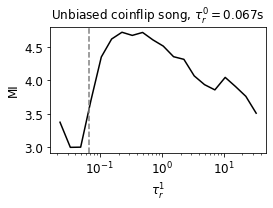

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3), tight_layout=True)
ax.semilogx(TAU_R_1S, mis, c='k')
ax.axvline(TAU_R_0, c='gray', ls='--')
set_plot(ax, x_label=r'$\tau_r^1$', y_label='MI', title='Unbiased coinflip song, ' + r'$\tau_r^0 = $' + f'{TAU_R_0:.3f}s')